# WGAN MNIST

This notebook is for implementing `Wasserstein GAN (WGAN)` from the paper [Wasserstein GAN](https://arxiv.org/abs/1701.07875) with [Tensorflow](https://www.tensorflow.org). <br>
[MNIST data](http://yann.lecun.com/exdb/mnist/) will be used.

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections), [Jonathan Hui's Blog](https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import datetime
import os

## Parameters


In [3]:
algorithm = WGAN_MNIST

img_size   = 28

batch_size = 128
num_epoch  = 50

n_latent = 100

beta1 = 0.5

learning_rate_g = 0.0002
learning_rate_d = 0.0002

show_result_epoch = 5

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
train_model = True

save_path = "./saved_models/" + date_time + "_" + algorithm
load_path = "./saved_models/20190809-11-04-47_WGAN_MNIST/model/model" 

# WGAN Parateter
n_critic = 1
c = 0.01 

## Import MNIST Dataset

Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

In [4]:
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [5]:
x_train = mnist[0][0]
y_train = mnist[0][1]
x_test  = mnist[1][0]
y_test  = mnist[1][1]

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


## Generator

In [6]:
def Generator(x, is_training, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        xavier_init_conv = tf.contrib.layers.xavier_initializer_conv2d()
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        # Project and Reshape 
        w1 = tf.get_variable('w1', [x.get_shape()[1], 7*7*1024], initializer=xavier_init)
        b1 = tf.get_variable('b1', [7*7*1024], initializer=xavier_init)
        
        x_project = tf.matmul(x,w1)+b1
        x_reshape = tf.reshape(x_project, (-1, 7, 7, 1024))
        
        # First deconv layer
        h1 = tf.layers.conv2d_transpose(x_reshape,filters=512, kernel_size=5, strides=1, padding='SAME', kernel_initializer=xavier_init_conv)
        h1 = tf.nn.leaky_relu(h1)
        
        # Second deconv layer
        h2 = tf.layers.conv2d_transpose(h1,filters=256, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)  
        
        # Third deconv layer 
        h3 = tf.layers.conv2d_transpose(h2, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, filters=1, kernel_size=5, strides=1, padding='SAME', kernel_initializer=xavier_init_conv)     
        output = tf.tanh(logits)
                
        return output

## Discriminator

In [7]:
def Discriminator(x, is_training, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        xavier_init_conv = tf.contrib.layers.xavier_initializer_conv2d()
        xavier_init = tf.contrib.layers.xavier_initializer()

        # First conv layer
        h1 = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h1 = tf.nn.leaky_relu(h1)
        
        # Second conv layer
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)
        
        # Trhid conv layer
        h3 = tf.layers.conv2d(h2, filters=256, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        flatten = tf.reshape(h3, (-1, h3.get_shape()[1]*h3.get_shape()[2]*h3.get_shape()[3]))
        
        logit  = tf.layers.dense(flatten, 1, kernel_initializer=xavier_init)
        output = tf.sigmoid(logit)  

        return logit, output

## GAN

In [8]:
def GAN(x, z, is_training):
    # Generator
    G = Generator(z, is_training)
    
    # Discriminator
    D_logit_real, D_out_real = Discriminator(x, is_training)
    D_logit_fake, D_out_fake = Discriminator(G, is_training, reuse=True)
    
    # get loss 
    ########################################### WGAN ###########################################
    d_loss = -tf.reduce_mean(D_logit_real) + tf.reduce_mean(D_logit_fake)
    g_loss = -tf.reduce_mean(D_logit_fake) 
    ############################################################################################

    return d_loss, g_loss, G

## Build Graph

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 1])
x_normalize = (tf.cast(x, tf.float32) - (255.0/2)) / (255.0/2)

z = tf.placeholder(tf.float32, shape=[None, n_latent])

is_training = tf.placeholder(tf.bool)

d_loss, g_loss, G = GAN(x_normalize, z, is_training) 

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('Discriminator')]
trainable_variables_g = [var for var in trainable_variables if var.name.startswith('Generator')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step_d = tf.train.AdamOptimizer(learning_rate_d).minimize(d_loss, var_list=trainable_variables_d)
    train_step_g = tf.train.AdamOptimizer(learning_rate_g).minimize(g_loss, var_list=trainable_variables_g)

##################### WGAN #####################
for d_var in trainable_variables_d:
    d_var = tf.clip_by_value(d_var, -c, c)
################################################

## Initialization

In [10]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [ ]:
Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

## Train

Epoch: 1 / G Loss: 330.15402 / D Loss: -670.21545


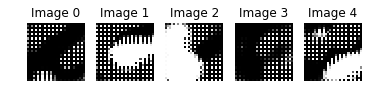

Epoch: 2 / G Loss: 785.24725 / D Loss: -1566.26807
Epoch: 3 / G Loss: 1357.65955 / D Loss: -2711.60010
Epoch: 4 / G Loss: 1577.32031 / D Loss: -2823.43311
Epoch: 5 / G Loss: 611.21527 / D Loss: -1446.52039


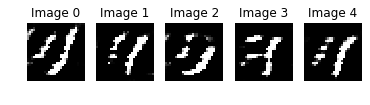

Epoch: 6 / G Loss: 1355.44446 / D Loss: -719.04980
Epoch: 7 / G Loss: 2044.65515 / D Loss: -3760.02051
Epoch: 8 / G Loss: 2802.60034 / D Loss: -5100.10547
Epoch: 9 / G Loss: 1175.83557 / D Loss: -3310.80518
Epoch: 10 / G Loss: 1227.37366 / D Loss: -2064.41675


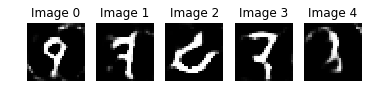

Epoch: 11 / G Loss: 3435.93237 / D Loss: -5707.10547
Epoch: 12 / G Loss: 3696.28833 / D Loss: -6621.90918
Epoch: 13 / G Loss: 4476.42578 / D Loss: -4728.26807
Epoch: 14 / G Loss: 5736.16553 / D Loss: -7754.96289
Epoch: 15 / G Loss: 5673.79150 / D Loss: -11315.77441


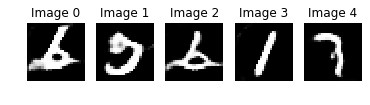

Epoch: 16 / G Loss: 7634.92334 / D Loss: -9851.17285
Epoch: 17 / G Loss: 9561.72852 / D Loss: -15936.99902
Epoch: 18 / G Loss: 9267.37793 / D Loss: -13444.48438
Epoch: 19 / G Loss: 8825.69922 / D Loss: -19277.15234
Epoch: 20 / G Loss: 9930.48340 / D Loss: -17144.47852


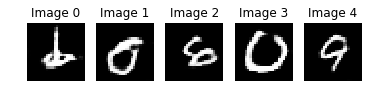

Epoch: 21 / G Loss: 10290.04004 / D Loss: -16380.88770
Epoch: 22 / G Loss: 10937.06934 / D Loss: -15040.37891
Epoch: 23 / G Loss: 10154.62207 / D Loss: -16068.07227
Epoch: 24 / G Loss: 12295.48730 / D Loss: -17289.25781
Epoch: 25 / G Loss: 11402.48926 / D Loss: -18873.01562


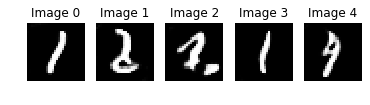

Epoch: 26 / G Loss: 13244.80176 / D Loss: -19926.41406
Epoch: 27 / G Loss: 14286.44434 / D Loss: -22847.92578
Epoch: 28 / G Loss: 10179.46191 / D Loss: -22409.81250
Epoch: 29 / G Loss: 14648.28516 / D Loss: -27452.44141
Epoch: 30 / G Loss: 13703.06738 / D Loss: -23433.27148


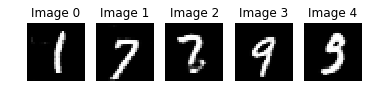

Epoch: 31 / G Loss: 18929.20312 / D Loss: -35151.83594
Epoch: 32 / G Loss: 22658.90430 / D Loss: -38384.08203
Epoch: 33 / G Loss: 14485.93750 / D Loss: -21329.91211
Epoch: 34 / G Loss: 22826.25000 / D Loss: -38109.11719
Epoch: 35 / G Loss: 10200.89648 / D Loss: -26774.98633


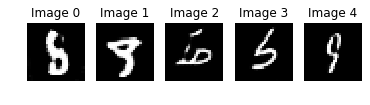

Epoch: 36 / G Loss: 19564.13672 / D Loss: -38826.32422
Epoch: 37 / G Loss: 16683.44336 / D Loss: -29648.39062
Epoch: 38 / G Loss: 14310.97949 / D Loss: -30960.68359
Epoch: 39 / G Loss: 23721.05273 / D Loss: -21793.11523
Epoch: 40 / G Loss: 11450.45801 / D Loss: -19286.83008


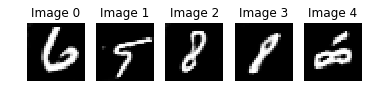

Epoch: 41 / G Loss: 26381.58008 / D Loss: -43444.85547
Epoch: 42 / G Loss: 29631.07617 / D Loss: -52336.70312
Epoch: 43 / G Loss: 31394.95312 / D Loss: -54473.32031
Epoch: 44 / G Loss: 25429.70312 / D Loss: -47104.94922
Epoch: 45 / G Loss: 32512.47656 / D Loss: -36634.25000


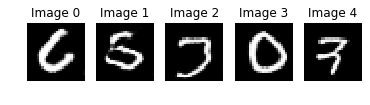

Epoch: 46 / G Loss: 34842.50781 / D Loss: -58659.47656
Epoch: 47 / G Loss: 41001.61328 / D Loss: -54539.04688
Epoch: 48 / G Loss: 6317.50195 / D Loss: -33762.17188
Epoch: 49 / G Loss: 26474.24414 / D Loss: -50399.87891
Epoch: 50 / G Loss: 25855.01758 / D Loss: -41310.01172


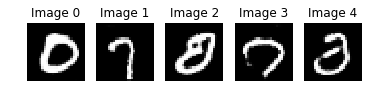

In [11]:
if train_model:
    # Training
    data_x = x_train
    len_data = x_train.shape[0]

    for i in range(num_epoch):
        # Shuffle the data 
        np.random.shuffle(data_x)

        # Making mini-batch
        for j in range(0, len_data, batch_size):
            if j + batch_size < len_data:
                data_x_in = data_x[j : j + batch_size, :]
            else:
                data_x_in = data_x[j : len_data, :]

            data_x_in = data_x_in.reshape((-1, img_size, img_size, 1))

            sampled_z = np.random.uniform(-1, 1, size=(data_x_in.shape[0] , n_latent))

            # Run Optimizer!
            G_out = sess.run(G, feed_dict = {x: data_x_in, z: sampled_z, is_training: True})

            ########################################### WGAN ###########################################
            for iter_d in range(n_critic):
                _, loss_d = sess.run([train_step_d, d_loss], feed_dict = {x: data_x_in, z: sampled_z, is_training: True})
            ############################################################################################

            _, loss_g = sess.run([train_step_g, g_loss], feed_dict = {x: data_x_in, z: sampled_z, is_training: True})

            print("Batch: {} / {}".format(j, len_data), end="\r")

        # Print Progess
        print("Epoch: {} / G Loss: {:.5f} / D Loss: {:.5f}".format((i+1), loss_g, loss_d))

        # Show test images 
        z_test = np.random.uniform(-1, 1, size=(5, n_latent))
        G_out = sess.run(G, feed_dict = {z: z_test, is_training: False})

        if i == 0 or (i+1) % show_result_epoch == 0:
            f, ax = plt.subplots(1,5)
            for j in range(5):
                ax[j].imshow(G_out[j,:,:,0], cmap = 'gray')
                ax[j].axis('off')
                ax[j].set_title('Image '+str(j))

        plt.show()

## Image Generation

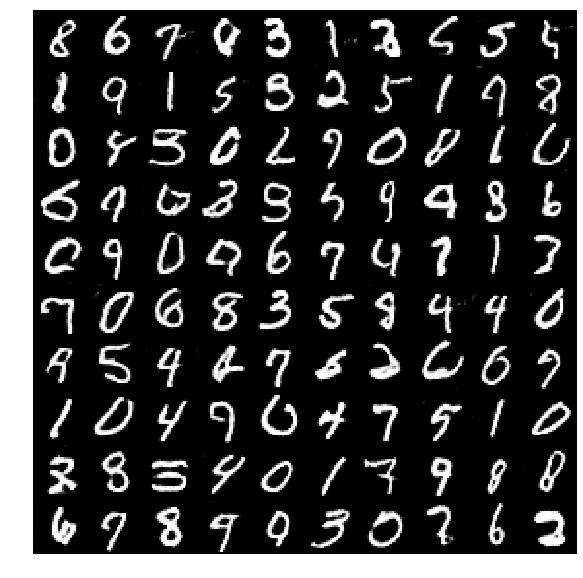

In [12]:
num_test = 10

img = np.zeros([img_size * num_test, img_size * num_test])

z_result = np.random.uniform(-1, 1, size=(num_test**2, n_latent))
G_result = sess.run(G, feed_dict = {z: z_result, is_training: False})

for i in range(num_test**2):
    row_num = int(i/num_test)
    col_num = int(i%num_test)
    
    img[row_num * img_size : (row_num + 1) * img_size, (col_num) * img_size : (col_num + 1) * img_size] = G_result[i,:,:,0]

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Save Model

In [ ]:
os.mkdir(save_path)

Saver.save(sess, save_path + "/model/model")
print("Model is saved in {}".format(save_path + "/model/model"))